In [1]:
# 1. 데이터 불러오기
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
fd001_train = pd.read_csv('../CMaps/Data/train_FD001_with_RUL.csv')
fd001_test  = pd.read_csv('../CMaps/Data/test_FD001_with_RUL.csv')


In [7]:
# --- NaN 진단 및 처리 ---
# FD001 train/test 데이터의 NaN 개수 확인
print('FD001 train NaN 개수:', fd001_train.isna().sum().sum())
print('FD001 test NaN 개수:', fd001_test.isna().sum().sum())

# NaN 값이 있으면 평균값으로 대체 (또는 필요시 제거)
fd001_train = fd001_train.fillna(fd001_train.mean())
fd001_test  = fd001_test.fillna(fd001_test.mean())
print('NaN 처리 후 FD001 train NaN 개수:', fd001_train.isna().sum().sum())
print('NaN 처리 후 FD001 test NaN 개수:', fd001_test.isna().sum().sum())
# ---

FD001 train NaN 개수: 0
FD001 test NaN 개수: 12996
NaN 처리 후 FD001 train NaN 개수: 0
NaN 처리 후 FD001 test NaN 개수: 0


In [8]:
# 2. RUL Clipping (상한치 125)
fd001_train['RUL'] = fd001_train['RUL'].clip(upper=125)
fd001_test['RUL'] = fd001_test['RUL'].clip(upper=125)

In [9]:
# 4. feature/target 분리 및 정규화
def get_feature_target(df):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X = df[feature_cols].values
    y = df['RUL'].values
    return X, y

scaler = StandardScaler()
X_train, y_train = get_feature_target(fd001_train)
X_test, y_test = get_feature_target(fd001_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# 5. 비시계열 모델
def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae

In [11]:
# Linear Regression
lr = LinearRegression()
lr_rmse, lr_mae = run_model(lr, X_train, y_train, X_test, y_test)

# XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_rmse, xgb_mae = run_model(xgb, X_train, y_train, X_test, y_test)

# RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rmse, rf_mae = run_model(rf, X_train, y_train, X_test, y_test)

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn_rmse, knn_mae = run_model(knn, X_train, y_train, X_test, y_test)

In [12]:
# 6. 시계열 모델 (LSTM, TCN)
def make_lstm_sequences(df, seq_len=30):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X, y = [], []
    for i in range(len(df) - seq_len + 1):
        X.append(df[feature_cols].iloc[i:i+seq_len].values)
        y.append(df['RUL'].iloc[i+seq_len-1])
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = keras.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [13]:
# LSTM-30
X_lstm_train, y_lstm_train = make_lstm_sequences(fd001_train, seq_len=30)
X_lstm_test, y_lstm_test = make_lstm_sequences(fd001_test, seq_len=30)
lstm = build_lstm((30, X_lstm_train.shape[2]))
lstm.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=64, verbose=0)
lstm_pred = lstm.predict(X_lstm_test).flatten()
lstm_rmse = np.sqrt(mean_squared_error(y_lstm_test, lstm_pred))
lstm_mae = mean_absolute_error(y_lstm_test, lstm_pred)

# LSTM-50
X_lstm_train50, y_lstm_train50 = make_lstm_sequences(fd001_train, seq_len=50)
X_lstm_test50, y_lstm_test50 = make_lstm_sequences(fd001_test, seq_len=50)
lstm50 = build_lstm((50, X_lstm_train50.shape[2]))
lstm50.fit(X_lstm_train50, y_lstm_train50, epochs=10, batch_size=64, verbose=0)
lstm50_pred = lstm50.predict(X_lstm_test50).flatten()
lstm50_rmse = np.sqrt(mean_squared_error(y_lstm_test50, lstm50_pred))
lstm50_mae = mean_absolute_error(y_lstm_test50, lstm50_pred)

408/408 [==============================] - 1s 2ms/step


In [14]:
# TCN (설치 필요: pip install keras-tcn)
try:
    from tcn import TCN
    def build_tcn(input_shape):
        model = keras.Sequential([
            TCN(input_shape=input_shape),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    X_tcn_train, y_tcn_train = make_lstm_sequences(fd001_train, seq_len=30)
    X_tcn_test, y_tcn_test = make_lstm_sequences(fd001_test, seq_len=30)
    tcn = build_tcn((30, X_tcn_train.shape[2]))
    tcn.fit(X_tcn_train, y_tcn_train, epochs=10, batch_size=64, verbose=0)
    tcn_pred = tcn.predict(X_tcn_test).flatten()
    tcn_rmse = np.sqrt(mean_squared_error(y_tcn_test, tcn_pred))
    tcn_mae = mean_absolute_error(y_tcn_test, tcn_pred)
except ImportError:
    tcn_rmse = tcn_mae = None


409/409 [==============================] - 2s 4ms/step


In [15]:
print(f'LinearRegression: RMSE={lr_rmse:.2f}, MAE={lr_mae:.2f}')
print(f'XGBoost: RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}')
print(f'RandomForest: RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}')
print(f'KNN: RMSE={knn_rmse:.2f}, MAE={knn_mae:.2f}')
print(f'LSTM-30: RMSE={lstm_rmse:.2f}, MAE={lstm_mae:.2f}')
print(f'LSTM-50: RMSE={lstm50_rmse:.2f}, MAE={lstm50_mae:.2f}')
print(f'TCN: RMSE={tcn_rmse}, MAE={tcn_mae}')

LinearRegression: RMSE=38.18, MAE=33.96
XGBoost: RMSE=39.43, MAE=37.31
RandomForest: RMSE=38.05, MAE=36.05
KNN: RMSE=39.22, MAE=36.94
LSTM-30: RMSE=13.83, MAE=13.54
LSTM-50: RMSE=13.31, MAE=13.01
TCN: RMSE=57.949366134505766, MAE=57.71373677092064


/var/folders/1w/f97855ms55x_bvptq4cmnmmh0000gn/T/ipykernel_1042/1217720499.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results, ax=axes[0], palette='Blues')
/var/folders/1w/f97855ms55x_bvptq4cmnmmh0000gn/T/ipykernel_1042/1217720499.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results, ax=axes[1], palette='Greens')


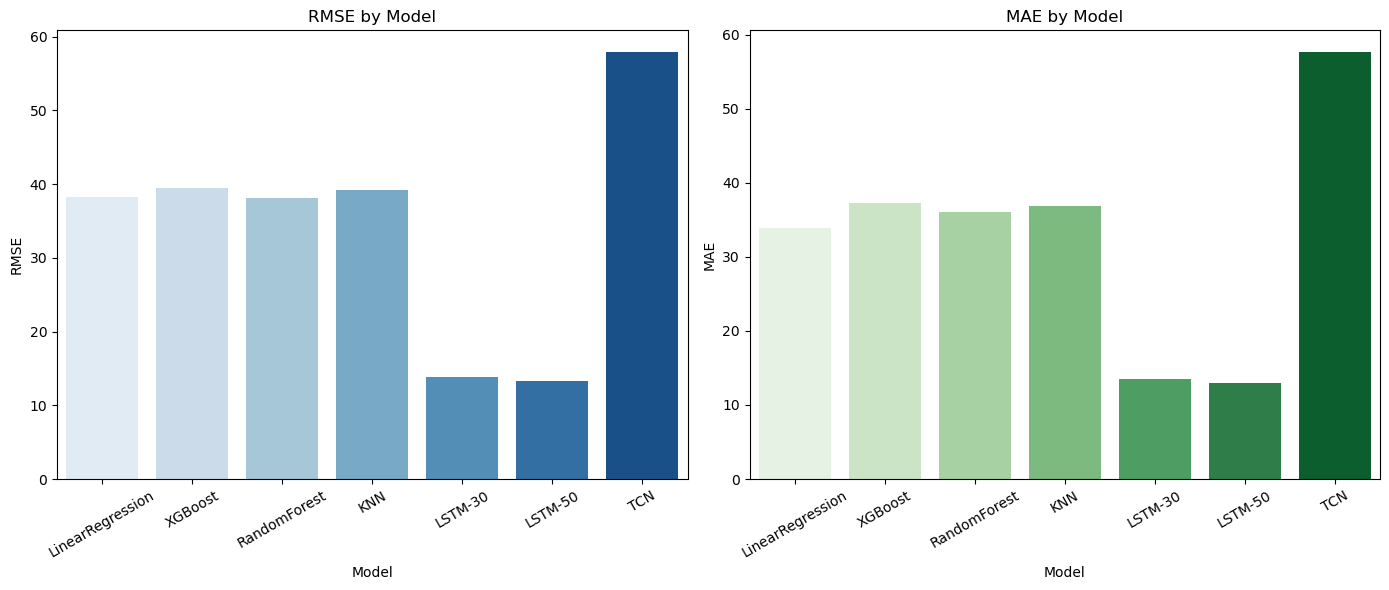

In [16]:
# 모델별 RMSE/MAE 시각화 (Bar Chart)
import matplotlib.pyplot as plt
import seaborn as sns
results = pd.DataFrame({
    'Model': ['LinearRegression', 'XGBoost', 'RandomForest', 'KNN', 'LSTM-30', 'LSTM-50', 'TCN'],
    'RMSE': [lr_rmse, xgb_rmse, rf_rmse, knn_rmse, lstm_rmse, lstm50_rmse, tcn_rmse],
    'MAE': [lr_mae, xgb_mae, rf_mae, knn_mae, lstm_mae, lstm50_mae, tcn_mae]
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='Model', y='RMSE', data=results, ax=axes[0], palette='Blues')
axes[0].set_title('RMSE by Model')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=30)

sns.barplot(x='Model', y='MAE', data=results, ax=axes[1], palette='Greens')
axes[1].set_title('MAE by Model')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [18]:
# 모델 저장 (models/ 폴더, 파일명에 '_clipped' 추가)
import joblib
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(lr, '../models/linear_regression_clipped.pkl')
joblib.dump(rf, '../models/random_forest_clipped.pkl')
joblib.dump(knn, '../models/knn_clipped.pkl')
joblib.dump(xgb, '../models/xgboost_clipped.pkl')
# LSTM, TCN 등 딥러닝 모델은 아래처럼 저장
# lstm.save('../models/lstm_model_clipped.h5')
# lstm50.save('../models/lstm50_model_clipped.h5')
# if 'tcn' in locals(): tcn.save('../models/tcn_model_clipped.h5')

['../models/xgboost_clipped.pkl']